작업하시기 편하게 BaseLine만들어놨습니다.
- 모델링 돌릴때, 각자 상황에 맞게 전처리를 바꾸시기도 하고, 
- 여유가 되면 다른모델을 시도해봐도  좋습니다.
- 즐거운 하루 보내세요

# Module Import 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

# Data Load

In [2]:
ifood_df = pd.read_csv('../ifood_df.csv')
project_df = pd.read_csv('../ml_project1_data.csv')

# Preprocessing

meat 이상치 제거했습니다.
wine은 이상치가 없더라구요

In [3]:
## 필요없는 변수 제거
project_df = project_df.drop(['Z_CostContact', 'Z_Revenue'], axis=1)

## 'MntMeatProducts' 이상치 제거(정규화는 아래에서 진행)
project_df = project_df.drop(project_df['MntMeatProducts'].sort_values(ascending=False).head(5).index)

## 'Income'결측치 제거와 정규화 
project_df = project_df[project_df['Income'].notna()].reset_index(drop=True)
project_df['Income']=StandardScaler().fit_transform(project_df['Income'].values.reshape(-1,1))

## 'Year_Birth'2023년으로 기준 나이 -> 고객등록일 기준으로 바꿀필요 있음!!
project_df['Year_Birth'] = project_df['Year_Birth'].apply(lambda x : np.abs(x-2015+1))

## 'Year_Birth' : normalization
project_df['Year_Birth']=StandardScaler().fit_transform(project_df['Year_Birth'].values.reshape(-1,1))

## 'Accept_all'변수 추가
accept_li = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp4', 'Response']
project_df['Accept_all'] = project_df[accept_li].sum(axis=1)

num_li = ['NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
Mnt_li = ['MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds']

## education 범주화
def make_education_column(x:str):
    if x == '2n Cycle':
        x = 0
    elif x == 'Basic':
        x = 1
    elif x == 'Graduation':
        x = 2
    elif x == 'Master':
        x = 3
    else :
        x = 4
    return x
project_df['Education'] = project_df['Education'].apply(lambda x : make_education_column(x))

## 'marital_status' 범주화 
dic_marital = {}
for ind, status in enumerate(set(project_df['Marital_Status'])) :
    dic_marital[status] = ind
project_df['Marital_Status'] = project_df['Marital_Status'].replace(dic_marital)

## 'Recency' 정규화 
project_df['Recency'] = StandardScaler().fit_transform(project_df['Recency'].values.reshape(-1,1))

## 'year', 'month', 'day' 변수 추가
project_df['year'] = project_df['Dt_Customer'].str.split('-').str.get(0).astype(int)
project_df['month'] = project_df['Dt_Customer'].str.split('-').str.get(1).astype(int)
project_df['day'] = project_df['Dt_Customer'].str.split('-').str.get(2).astype(int)

## 'Mnt_all'변수 추가 및 모든 Mnt변수들 정규화 
project_df['Mnt_all'] = project_df[Mnt_li].sum(axis=1)
mnt_every_li = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Mnt_all']

scaler = StandardScaler()            
scaler.fit(project_df[mnt_every_li])                  
df_s = scaler.transform(project_df[mnt_every_li])     
df_s = pd.DataFrame(df_s, columns = mnt_every_li)
project_df[mnt_every_li] = df_s

## 'Num_all'변수 추가 및 모든 Num변수 정규화 
project_df['Num_all'] = project_df[num_li].sum(axis=1)
num_every_li = ['NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Num_all'] 

scaler = StandardScaler() 
scaler.fit(project_df[num_every_li])                  
df_s = scaler.transform(project_df[num_every_li])     
df_s = pd.DataFrame(df_s, columns = num_every_li)
project_df[num_every_li] = df_s

project_df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Accept_all,year,month,day,Mnt_all,Num_all
0,5524,0.984767,2,1,0.241822,0,0,2012-09-04,0.310287,0.976449,...,0,0,0,1,1,2012,9,4,1.682224,1.634053
1,2174,1.235041,2,1,-0.232555,1,1,2014-03-08,-0.380975,-0.873339,...,0,0,0,0,0,2014,3,8,-0.961073,-1.265853
2,4141,0.317369,2,4,0.783813,0,0,2013-08-21,-0.795732,0.356889,...,0,0,0,0,0,2013,8,21,0.284103,0.667418
3,6182,-1.267702,2,4,-1.024847,1,0,2014-02-10,-0.795732,-0.873339,...,0,0,0,0,0,2014,2,10,-0.917849,-0.851580
4,5324,-1.017428,4,6,0.248057,1,0,2014-01-19,1.554558,-0.393105,...,0,0,0,0,0,2014,1,19,-0.304404,0.529327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,10870,0.150519,2,6,0.365907,0,1,2013-06-13,-0.104471,1.195815,...,0,0,0,0,0,2013,6,13,1.223388,0.391236
2208,4001,1.902439,4,4,0.478167,2,1,2014-06-10,0.241160,0.297601,...,1,0,0,0,1,2014,6,10,-0.267830,1.219781
2209,7270,-1.017428,2,7,0.195286,0,0,2014-01-25,1.450868,1.785732,...,0,0,0,0,2,2014,1,25,1.057143,0.667418
2210,8235,1.068191,3,4,0.688568,0,1,2014-01-24,-1.417868,0.362818,...,0,0,0,0,0,2014,1,24,0.395487,0.805509


In [4]:
pd.set_option('display.max_columns', None)

project_df



,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Accept_all,year,month,day,Mnt_all,Num_all
0,5524,0.984767,2,1,0.241822,0,0,2012-09-04,0.310287,0.976449,1.547500,1.773825,2.452093,1.482883,0.848301,0.370995,1.427441,2.685365,-0.558212,0.691516,0,0,0,0,0,0,1,1,2012,9,4,1.682224,1.634053
1,2174,1.235041,2,1,-0.232555,1,1,2014-03-08,-0.380975,-0.873339,-0.637919,-0.735580,-0.651734,-0.634638,-0.734119,-0.164672,-1.129831,-0.592997,-1.174669,-0.135536,0,0,0,0,0,0,0,0,2014,3,8,-0.961073,-1.265853
2,4141,0.317369,2,4,0.783813,0,0,2013-08-21,-0.795732,0.356889,0.567829,-0.173287,1.338367,-0.147851,-0.039398,-0.700338,1.427441,-0.228734,1.291160,-0.549063,0,0,0,0,0,0,0,0,2013,8,21,0.284103,0.667418
3,6182,-1.267702,2,4,-1.024847,1,0,2014-02-10,-0.795732,-0.873339,-0.562560,-0.670521,-0.505672,-0.585959,-0.753417,-0.164672,-0.764506,-0.957259,-0.558212,0.277990,0,0,0,0,0,0,0,0,2014,2,10,-0.917849,-0.851580
4,5324,-1.017428,4,6,0.248057,1,0,2014-01-19,1.554558,-0.393105,0.417111,-0.215111,0.151609,-0.001816,-0.560439,1.442329,0.331468,0.135528,0.058246,-0.135536,0,0,0,0,0,0,0,0,2014,1,19,-0.304404,0.529327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,10870,0.150519,2,6,0.365907,0,1,2013-06-13,-0.104471,1.195815,0.417111,0.082300,0.078578,2.213062,3.916652,-0.164672,1.792766,0.135528,-0.558212,-0.135536,0,0,0,0,0,0,0,0,2013,6,13,1.223388,0.391236
2208,4001,1.902439,4,4,0.478167,2,1,2014-06-10,0.241160,0.297601,-0.663039,-0.624051,-0.688250,-0.658977,-0.695524,2.513662,1.427441,-0.228734,-0.249983,0.691516,0,0,0,1,0,0,0,1,2014,6,10,-0.267830,1.219781
2209,7270,-1.017428,2,7,0.195286,0,0,2014-01-25,1.450868,1.785732,0.542709,0.244947,-0.104000,-0.366905,-0.386759,-0.700338,-0.764506,0.135528,2.215846,0.277990,0,1,0,0,0,0,0,2,2014,1,25,1.057143,0.667418
2210,8235,1.068191,3,4,0.688568,0,1,2014-01-24,-1.417868,0.362818,0.090554,0.231006,0.772375,0.071202,0.327260,-0.164672,0.696792,0.864053,1.291160,-0.962589,0,0,0,0,0,0,0,0,2014,1,24,0.395487,0.805509


# Feature Selection

In [5]:
features = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 
 'Teenhome', 'Recency', 
 'MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
 'Complain', 'Accept_all', 
 'year', 'month','day', 
 'Num_all']

classification_target = ['Response']
regression_target = ['Mnt_all']

# Data Split

In [6]:
project_df[features]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntMeatProducts,MntFruits,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Accept_all,year,month,day,Num_all
0,0.984767,2,1,0.241822,0,0,0.310287,0.976449,1.773825,1.547500,2.452093,1.482883,0.848301,0.370995,1.427441,2.685365,-0.558212,0.691516,0,0,0,0,0,0,1,2012,9,4,1.634053
1,1.235041,2,1,-0.232555,1,1,-0.380975,-0.873339,-0.735580,-0.637919,-0.651734,-0.634638,-0.734119,-0.164672,-1.129831,-0.592997,-1.174669,-0.135536,0,0,0,0,0,0,0,2014,3,8,-1.265853
2,0.317369,2,4,0.783813,0,0,-0.795732,0.356889,-0.173287,0.567829,1.338367,-0.147851,-0.039398,-0.700338,1.427441,-0.228734,1.291160,-0.549063,0,0,0,0,0,0,0,2013,8,21,0.667418
3,-1.267702,2,4,-1.024847,1,0,-0.795732,-0.873339,-0.670521,-0.562560,-0.505672,-0.585959,-0.753417,-0.164672,-0.764506,-0.957259,-0.558212,0.277990,0,0,0,0,0,0,0,2014,2,10,-0.851580
4,-1.017428,4,6,0.248057,1,0,1.554558,-0.393105,-0.215111,0.417111,0.151609,-0.001816,-0.560439,1.442329,0.331468,0.135528,0.058246,-0.135536,0,0,0,0,0,0,0,2014,1,19,0.529327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,0.150519,2,6,0.365907,0,1,-0.104471,1.195815,0.082300,0.417111,0.078578,2.213062,3.916652,-0.164672,1.792766,0.135528,-0.558212,-0.135536,0,0,0,0,0,0,0,2013,6,13,0.391236
2208,1.902439,4,4,0.478167,2,1,0.241160,0.297601,-0.624051,-0.663039,-0.688250,-0.658977,-0.695524,2.513662,1.427441,-0.228734,-0.249983,0.691516,0,0,0,1,0,0,1,2014,6,10,1.219781
2209,-1.017428,2,7,0.195286,0,0,1.450868,1.785732,0.244947,0.542709,-0.104000,-0.366905,-0.386759,-0.700338,-0.764506,0.135528,2.215846,0.277990,0,1,0,0,0,0,2,2014,1,25,0.667418
2210,1.068191,3,4,0.688568,0,1,-1.417868,0.362818,0.231006,0.090554,0.772375,0.071202,0.327260,-0.164672,0.696792,0.864053,1.291160,-0.962589,0,0,0,0,0,0,0,2014,1,24,0.805509


## Classification Split & Modeling

In [7]:
features = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 
 'Teenhome', 'Recency', 
 'MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
 'Complain', 'Accept_all', 
 'year', 'month','day', 
 'Num_all']

classification_target = ['Response']

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [8]:
X_train, X_test, y_train, y_test = train_test_split(project_df[features], project_df[classification_target],
                                                    test_size=0.2, random_state=42,
                                                    stratify = project_df[classification_target])


clf = RandomForestClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
clf.predict(X_test)

C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\801986344.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

여기에 
- 10 fold로 모델링 해주시고, 
- metric은 f1-score로 평가해주시고, 
- feature importance뽑아주세요. 
- 변수들 heatmap그려주세요

### 1

In [9]:
# Define the model
clf = RandomForestClassifier(max_depth=2, random_state=42)

# Define k-fold cross-validation
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [10]:
# Perform cross-validation and calculate f1-scores
f1_scores = cross_val_score(clf, project_df[features], project_df[classification_target], cv=kf, scoring='f1_macro')

C:\Users\jihoo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jihoo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jihoo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jihoo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

Mean f1-score: 0.5963682310065666
Standard deviation of f1-score: 0.04614820144771348


C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\929484872.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(project_df[features], project_df[classification_target])


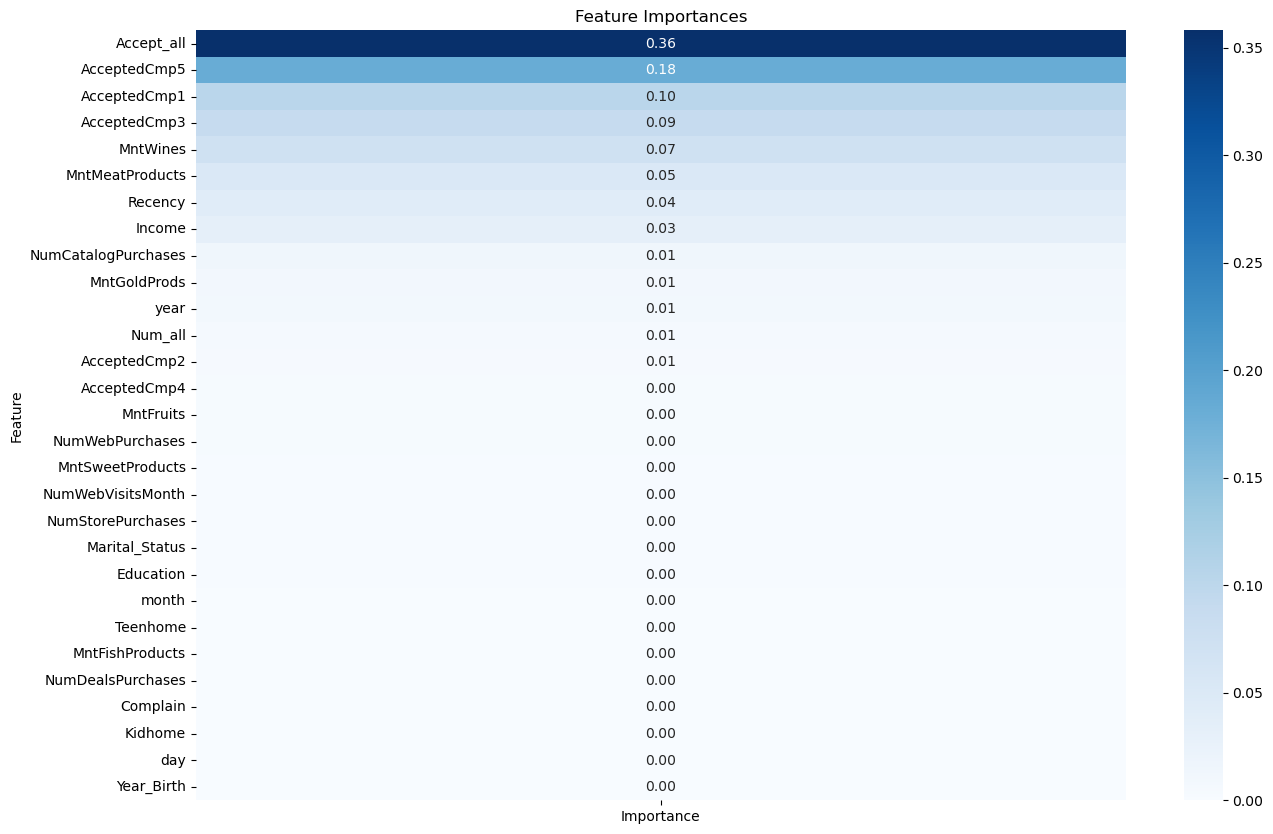

In [11]:
# Print the mean and standard deviation of f1-scores
print('Mean f1-score:', f1_scores.mean())
print('Standard deviation of f1-score:', f1_scores.std())

# Fit the model on the whole dataset and extract feature importances
clf.fit(project_df[features], project_df[classification_target])
importances = clf.feature_importances_

# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the features by importance
importances_df = importances_df.sort_values('Importance', ascending=False)

# Create a heatmap of feature importances
plt.figure(figsize=(15, 10))
sns.heatmap(importances_df.set_index('Feature'), cmap='Blues', annot=True, fmt='.2f')
plt.title('Feature Importances')
plt.show()

<AxesSubplot:>

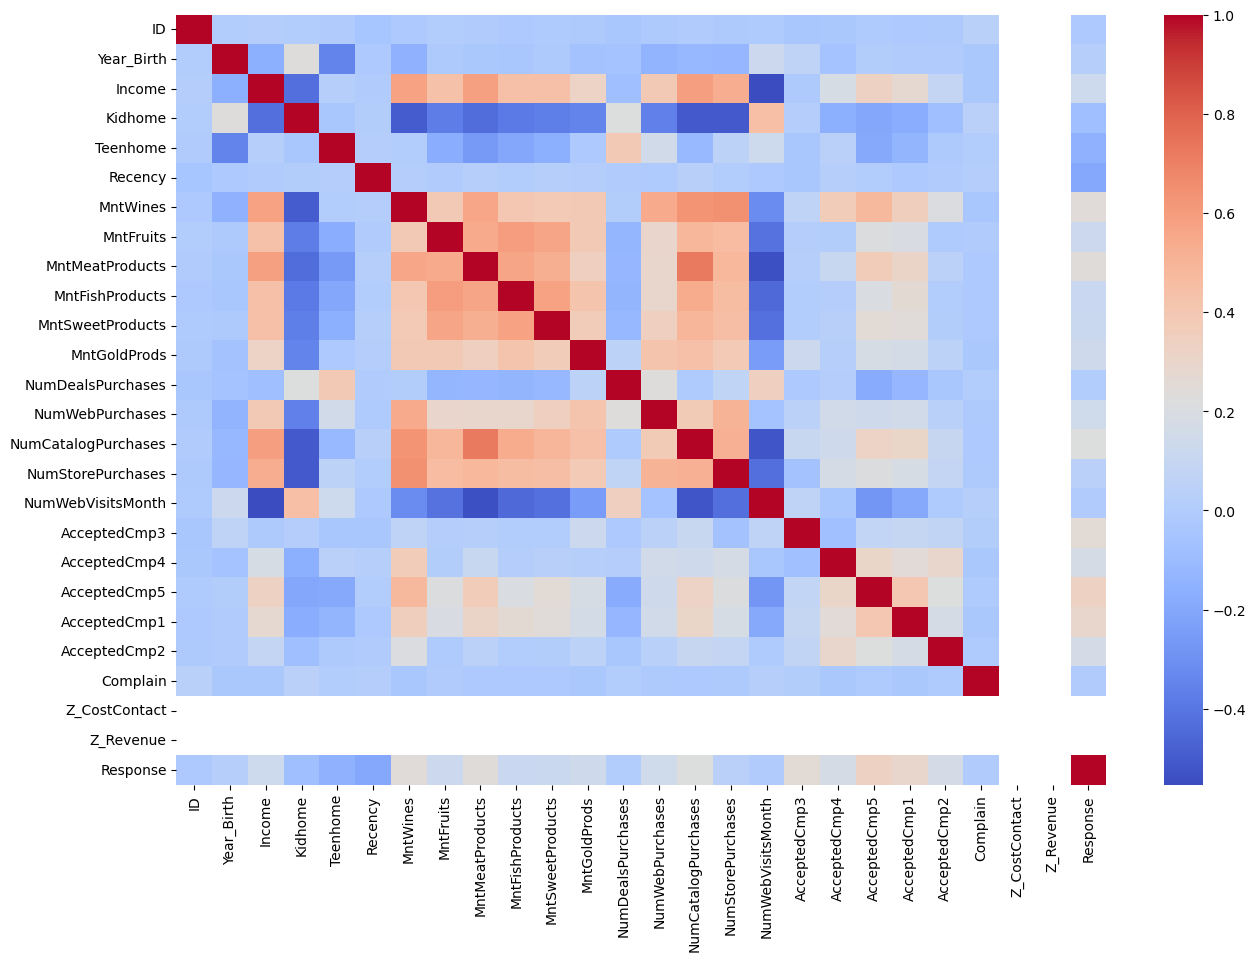

In [12]:
# 데이터 불러오기
data = pd.read_csv('../ml_project1_data.csv')

# heatmap 그리기
fig, ax2 = plt.subplots(figsize=(15, 10))
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', ax=ax2)


#cool 계열은 파란색 계열로 낮은 값을, warm 계열은 붉은색 계열로 높은 값

### 2 
- Accept_all : 0.3
- accept_cmp5 : 0.2
- accept_cmp1,3 : 0.9, 0.8
등의 피쳐들을 제외한 값입니다.

In [13]:
features = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 
 'Teenhome', 'Recency', 
 'MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
# 'AcceptedCmp3', 'AcceptedCmp5', 'Accept_all', 'AcceptedCmp1', 
#  'AcceptedCmp4', 'AcceptedCmp2', 
 'Complain',
 'year', 'month','day', 
 'Num_all']

classification_target = ['Response']

C:\Users\jihoo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jihoo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jihoo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jihoo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

Mean f1-score: 0.45922530895617425
Standard deviation of f1-score: 0.006547410154506702


C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\4204447096.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(project_df[features], project_df[classification_target])


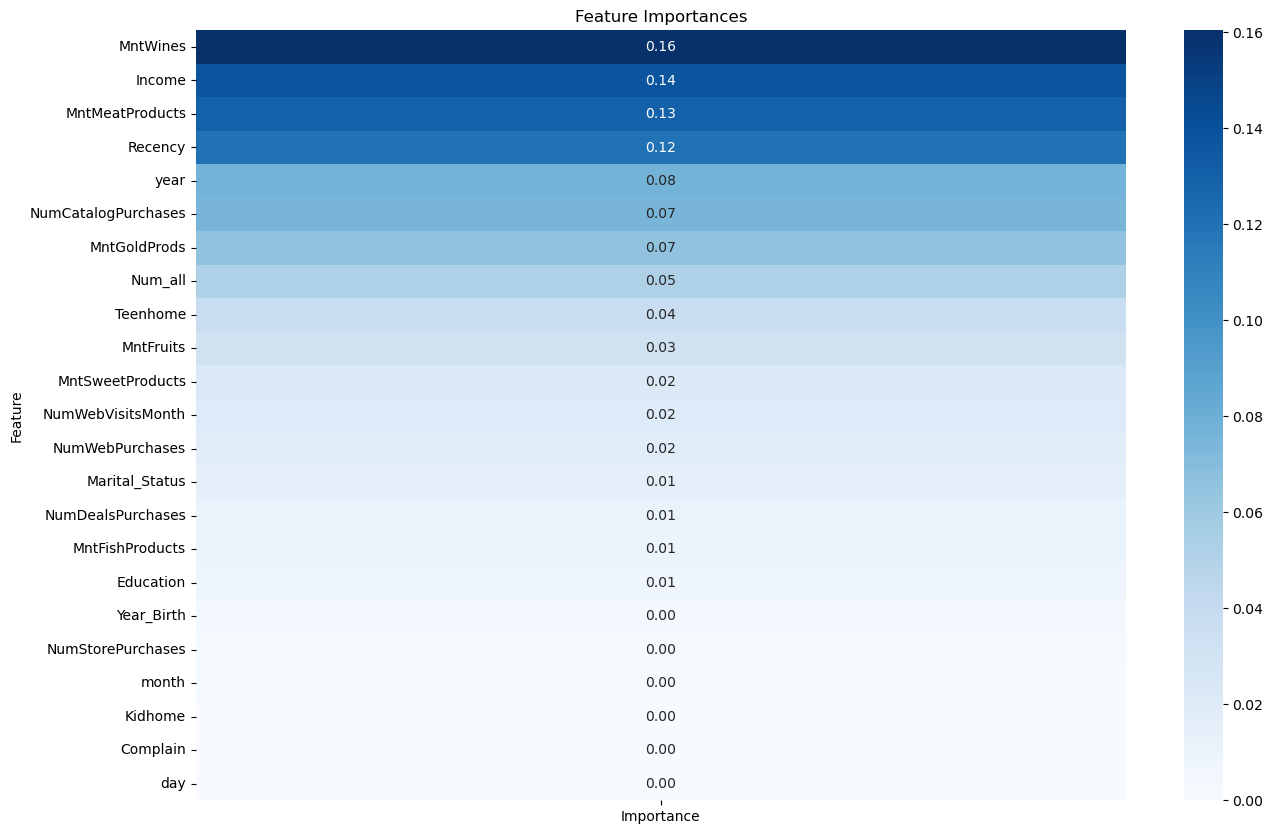

In [14]:
# Define the model
clf = RandomForestClassifier(max_depth=2, random_state=42)

# Define k-fold cross-validation
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Perform cross-validation and calculate f1-scores
f1_scores = cross_val_score(clf, project_df[features], project_df[classification_target], cv=kf, scoring='f1_macro')

# Print the mean and standard deviation of f1-scores
print('Mean f1-score:', f1_scores.mean())
print('Standard deviation of f1-score:', f1_scores.std())

# Fit the model on the whole dataset and extract feature importances
clf.fit(project_df[features], project_df[classification_target])
importances = clf.feature_importances_

# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the features by importance
importances_df = importances_df.sort_values('Importance', ascending=False)

# Create a heatmap of feature importances
plt.figure(figsize=(15, 10))
sns.heatmap(importances_df.set_index('Feature'), cmap='Blues', annot=True, fmt='.2f')
plt.title('Feature Importances')
plt.show()

<AxesSubplot:>

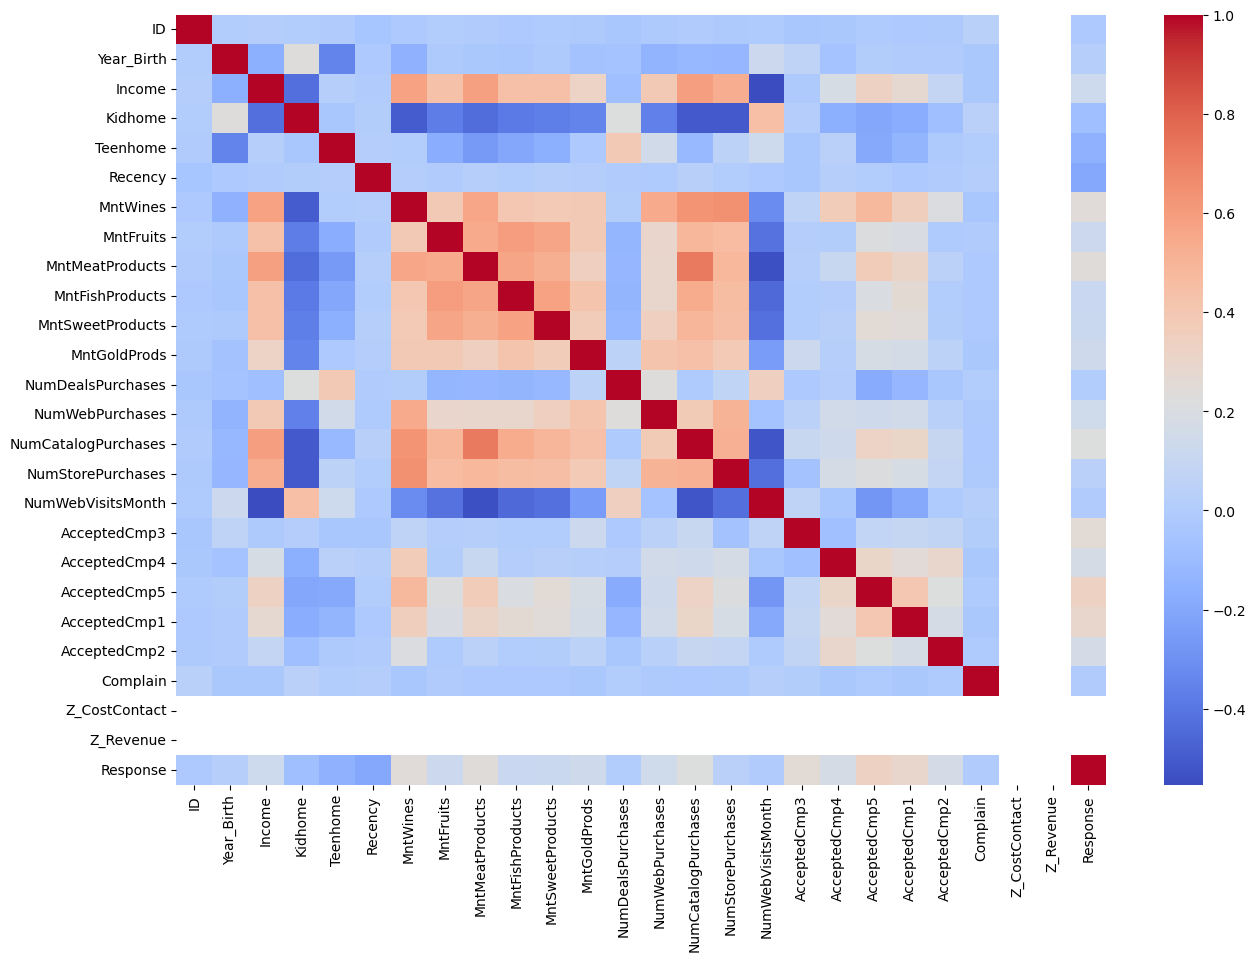

In [15]:
# 데이터 불러오기
data = pd.read_csv('../ml_project1_data.csv')

# heatmap 그리기
fig, ax2 = plt.subplots(figsize=(15, 10))
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', ax=ax2)


#cool 계열은 파란색 계열로 낮은 값을, warm 계열은 붉은색 계열로 높은 값

## Regression Split & Modeling

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

In [16]:
X_train, X_test, y_train, y_test = train_test_split(project_df[features], project_df[regression_target],
                                                    test_size=0.2, random_state=42,
                                                    stratify = project_df[classification_target])

regr = RandomForestRegressor(max_depth=2, random_state=42)
regr.fit(X_train, y_train)
regr.predict(X_test)

C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\3772058761.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


array([ 0.95572459, -0.80870225,  0.49020051, -0.80870225,  1.17607874,
       -0.80870225, -0.80870225,  1.49304992,  0.65441319, -0.80870225,
        1.27392913, -0.62523984, -0.79566273,  1.03535076, -0.80870225,
        0.67044979, -0.80870225, -0.80870225, -0.80870225,  1.47158714,
        0.31373926, -0.80870225,  0.3611185 ,  0.51421387, -0.80870225,
       -0.80870225,  0.58098819,  0.79020452,  1.27392913,  0.95572459,
       -0.80870225, -0.80870225, -0.14127149, -0.80870225, -0.7806768 ,
        1.15492709, -0.7806768 , -0.80870225,  0.3086234 ,  0.20765468,
       -0.80870225,  0.31216895,  0.31877694,  1.07908044,  0.3086234 ,
        1.49304992, -0.80870225,  0.34704013,  0.66021619, -0.79566273,
        0.3086234 , -0.80870225,  0.32646537, -0.80870225,  0.95572459,
        1.59090031, -0.80870225,  1.27392913,  0.3611185 ,  0.81727541,
        1.15492709, -0.80870225, -0.80870225, -0.80870225, -0.80870225,
        0.04682275,  1.07908044, -0.14127149, -0.80870225, -0.80

여기에 
- 10 fold로 모델링 해주시고,
- metric은 MSE로 평가해주시고, 
- feature importance뽑아주세요. 
- 변수들 heatmap그려주세요

### 1

In [17]:
plt.rc("font", family="Malgun Gothic")

In [18]:
features = [
 'Year_Birth',
 'Education',
 'Marital_Status', 'Income', 'Kidhome', 
 'Teenhome', 'Recency', 
 'MntWines', 'MntMeatProducts',
 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
 'NumDealsPurchases', 'NumWebPurchases',
 'NumCatalogPurchases', 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
 'Complain', 'Accept_all', 
 'year', 'month','day', 
 'Num_all'
           ]

regression_target = ['Mnt_all']

C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\3416336746.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\3416336746.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\3416336746.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\3416336746.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y

mean: 0.11118365041418037
std: 0.01721980420762074
중요 순위:
1 MntWines 0.5072923776929642
2 MntMeatProducts 0.4255442779316351
3 NumCatalogPurchases 0.0559926286345982
4 Income 0.0078673408521149
5 NumStorePurchases 0.003303374888687669
6 Num_all 0.0
7 MntGoldProds 0.0
8 Education 0.0
9 Marital_Status 0.0
10 Kidhome 0.0
11 Teenhome 0.0
12 Recency 0.0
13 MntFruits 0.0
14 MntFishProducts 0.0
15 MntSweetProducts 0.0
16 NumWebPurchases 0.0
17 NumDealsPurchases 0.0
18 day 0.0
19 NumWebVisitsMonth 0.0
20 AcceptedCmp3 0.0
21 AcceptedCmp4 0.0
22 AcceptedCmp5 0.0
23 AcceptedCmp1 0.0
24 AcceptedCmp2 0.0
25 Complain 0.0
26 Accept_all 0.0
27 year 0.0
28 month 0.0
29 Year_Birth 0.0


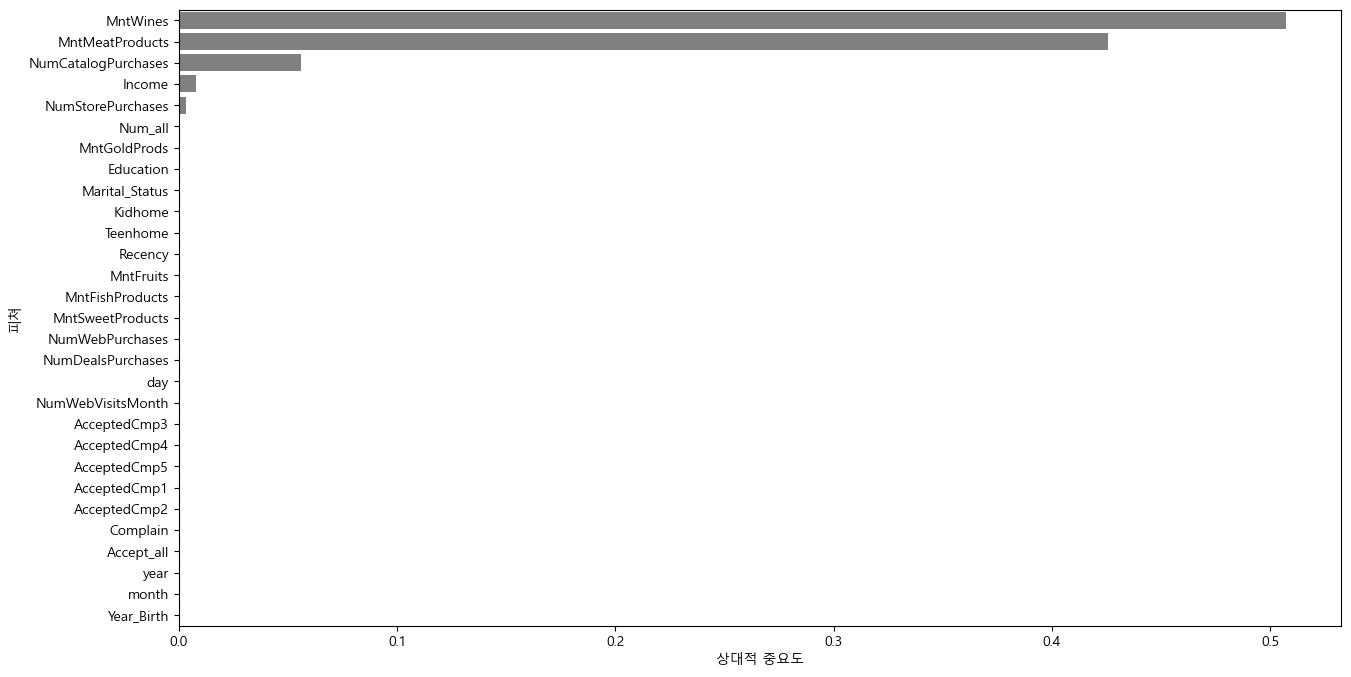

C:\Users\jihoo\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\jihoo\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


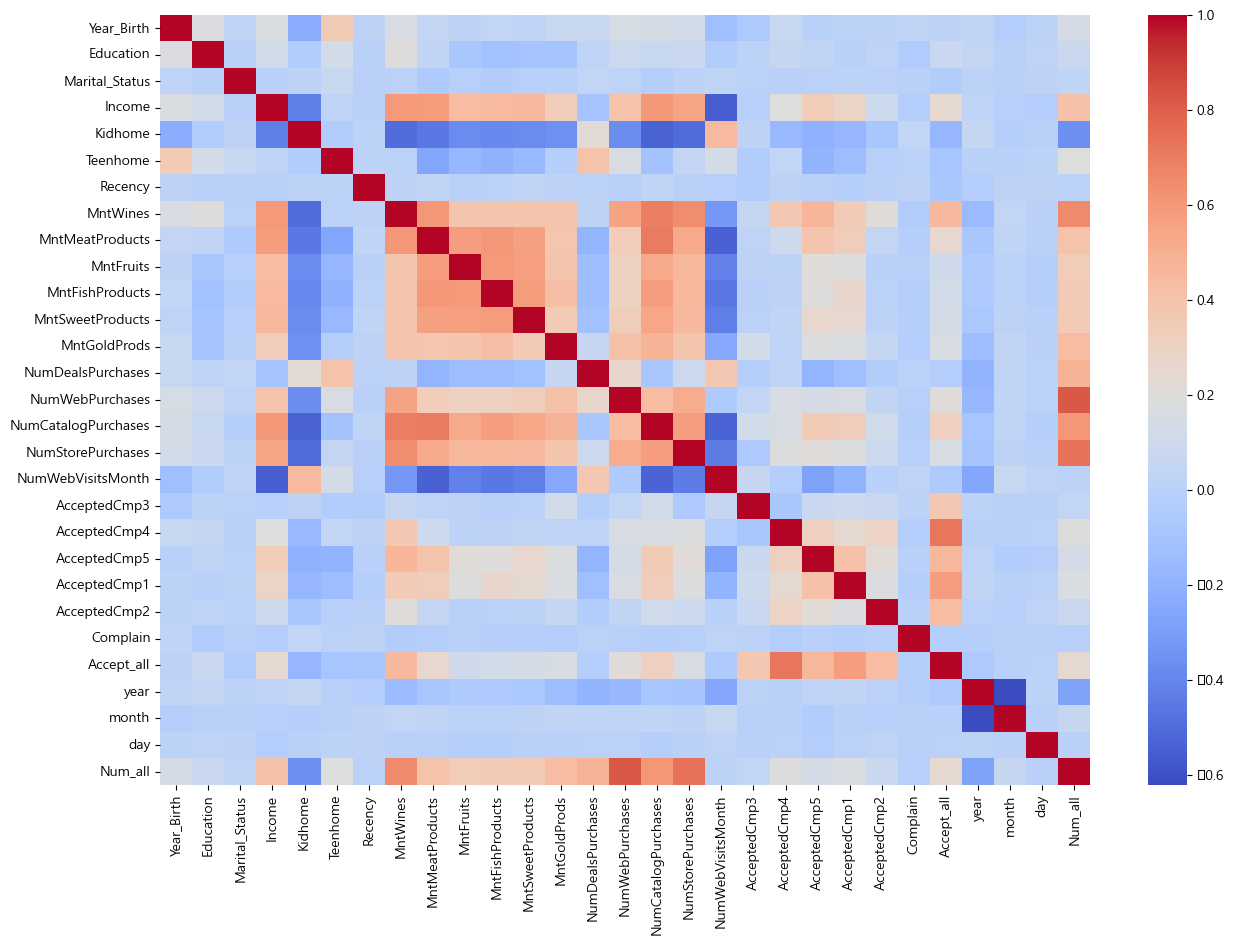

In [19]:
# 10fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

regr = RandomForestRegressor(max_depth=2, random_state=42)

mse_list = []

'''
X_train, X_test, y_train, y_test = train_test_split(project_df[features], project_df[regression_target],
                                                    test_size=0.2, random_state=42,
                                                    stratify = project_df[classification_target])

regr = RandomForestRegressor(max_depth=2, random_state=42)
regr.fit(X_train, y_train)
regr.predict(X_test)

'''
# 폴드마다 forloop
for train_index, test_index in kf.split(project_df[features], project_df[regression_target]):

    # 
    X_train, X_test = project_df[features].iloc[train_index], project_df[features].iloc[test_index]
    y_train, y_test = project_df[regression_target].iloc[train_index], project_df[regression_target].iloc[test_index]
    
    regr.fit(X_train, y_train)
    
    # 예측 및 mse 계산
    y_predict = regr.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    mse_list.append(mse)

# mse들 mean과 std
mse_mean = np.mean(mse_list)
mse_std = np.std(mse_list)

print("mean:", mse_mean)
print("std:", mse_std)

# featrue importance 뽑기
importance = regr.feature_importances_

# 정렬 인덱스
index = np.argsort(importance)[::-1]

# 순위와 값
print("중요 순위:")
for i in range(len(features)):
    print(i + 1, features[index[i]], importance[index[i]])

# 중요도 그림
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=importance[index], y=np.array(features)[index], color='gray')
plt.xlabel("상대적 중요도")
plt.ylabel("피쳐")
plt.show()

# 히트맵
fig, ax2 = plt.subplots(figsize=(15, 10))
sns.heatmap(project_df[features].corr(), annot=False, cmap="coolwarm", ax=ax2)
plt.show()


### 2

Mnt_all이 타겟이므로 다른 mnt들을 다 빼보았습니다

In [20]:
features = [
 'Year_Birth',
 'Education',
 'Marital_Status', 'Income', 'Kidhome', 
 'Teenhome', 'Recency', 
# 'MntWines', 'MntMeatProducts',
# 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
 'NumDealsPurchases', 'NumWebPurchases',
 'NumCatalogPurchases', 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
 'Complain', 'Accept_all', 
 'year', 'month','day', 
 'Num_all'
           ]

regression_target = ['Mnt_all']

C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\2375164587.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\2375164587.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\2375164587.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\jihoo\AppData\Local\Temp\ipykernel_29088\2375164587.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y

mean: 0.20626272973867094
std: 0.02317768626893528
중요 순위:
1 NumCatalogPurchases 0.637401118384845
2 Income 0.25770431628609164
3 NumStorePurchases 0.07294744431758701
4 Num_all 0.026490265393261755
5 AcceptedCmp5 0.004159587543444113
6 Teenhome 0.001297268074770563
7 Education 0.0
8 Marital_Status 0.0
9 Kidhome 0.0
10 Recency 0.0
11 NumDealsPurchases 0.0
12 NumWebPurchases 0.0
13 NumWebVisitsMonth 0.0
14 day 0.0
15 AcceptedCmp3 0.0
16 AcceptedCmp4 0.0
17 AcceptedCmp1 0.0
18 AcceptedCmp2 0.0
19 Complain 0.0
20 Accept_all 0.0
21 year 0.0
22 month 0.0
23 Year_Birth 0.0


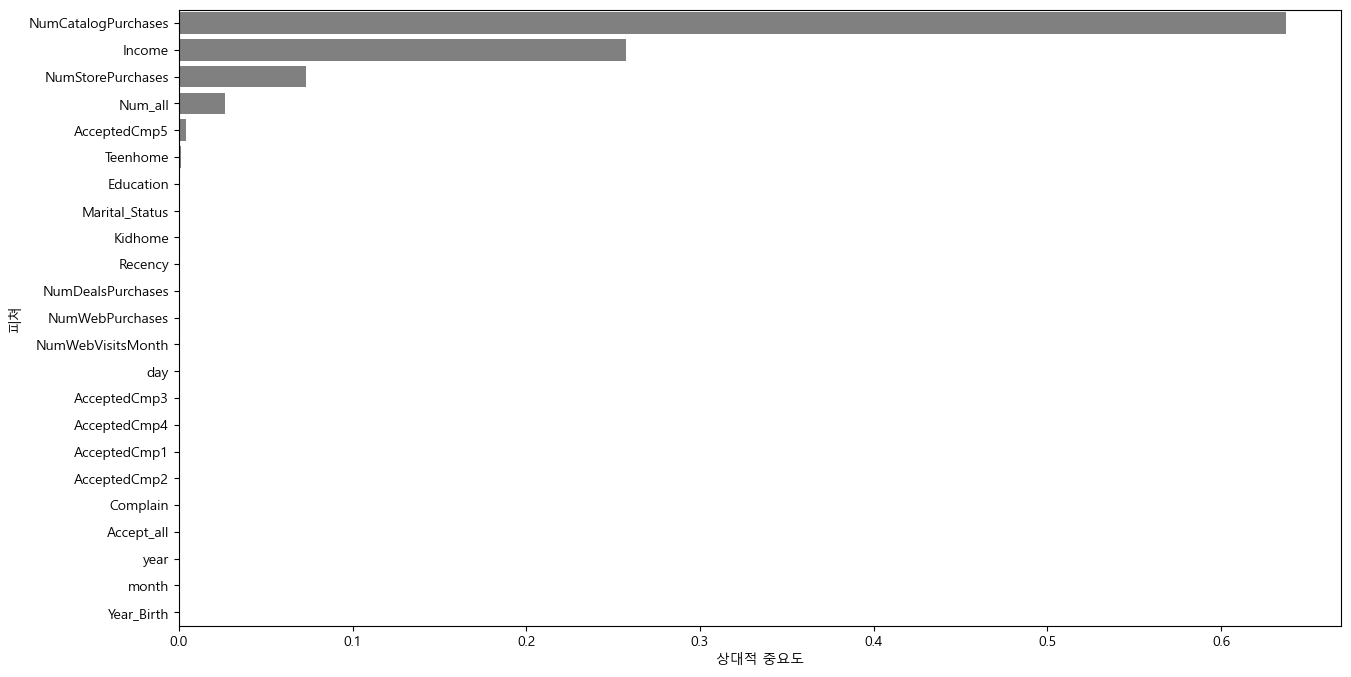

C:\Users\jihoo\Anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\jihoo\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


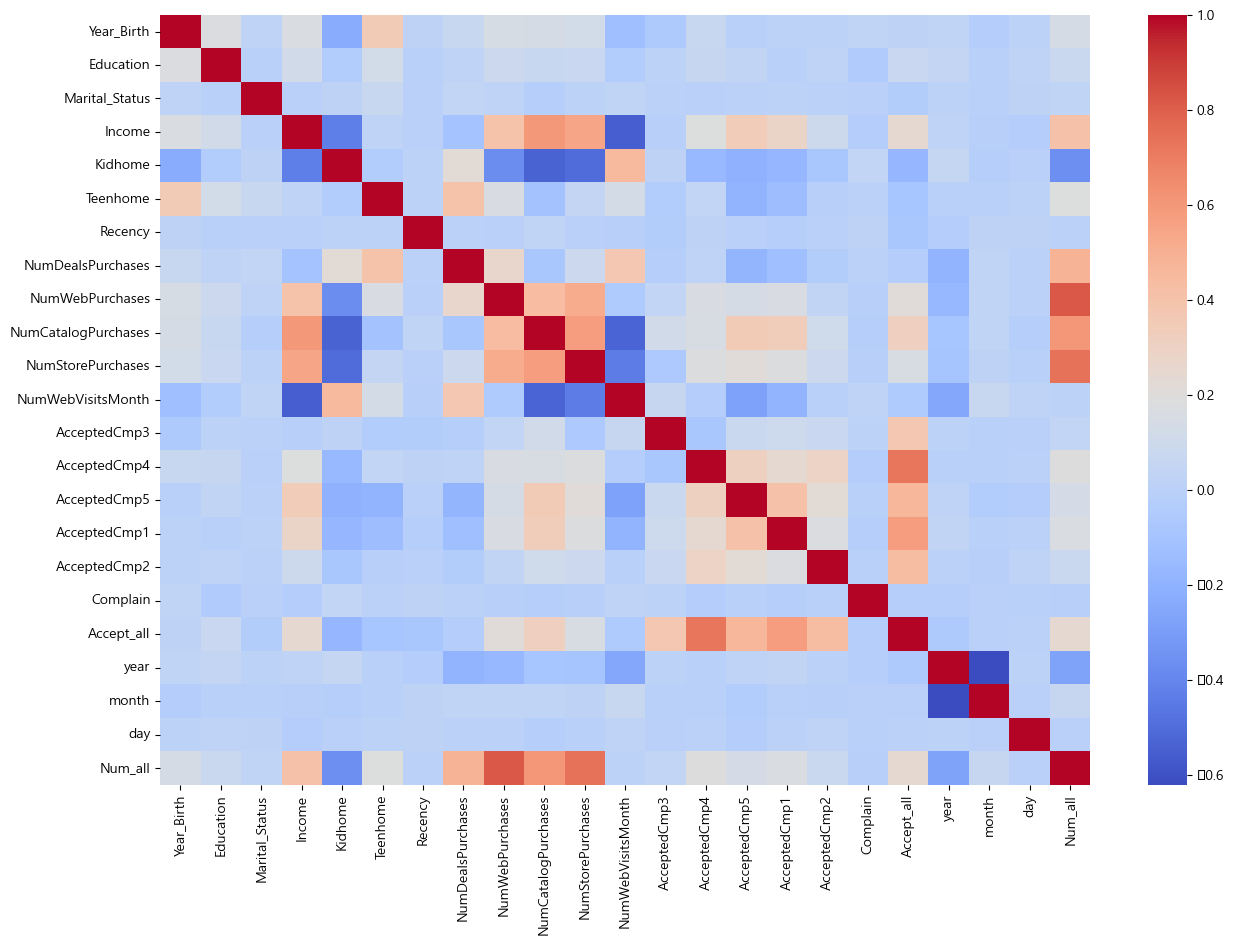

In [21]:
# 10fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

regr = RandomForestRegressor(max_depth=2, random_state=42)

mse_list = []

'''
X_train, X_test, y_train, y_test = train_test_split(project_df[features], project_df[regression_target],
                                                    test_size=0.2, random_state=42,
                                                    stratify = project_df[classification_target])

regr = RandomForestRegressor(max_depth=2, random_state=42)
regr.fit(X_train, y_train)
regr.predict(X_test)

'''
# 폴드마다 forloop
for train_index, test_index in kf.split(project_df[features], project_df[regression_target]):

    X_train, X_test = project_df[features].iloc[train_index], project_df[features].iloc[test_index]
    y_train, y_test = project_df[regression_target].iloc[train_index], project_df[regression_target].iloc[test_index]
    regr.fit(X_train, y_train)
    
    y_predict = regr.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    mse_list.append(mse)

# mse들 mean과 std
mse_mean = np.mean(mse_list)
mse_std = np.std(mse_list)

print("mean:", mse_mean)
print("std:", mse_std)

# featrue importance 뽑기
importance = regr.feature_importances_

# 정렬 인덱스
index = np.argsort(importance)[::-1]

# 순위와 값
print("중요 순위:")
for i in range(len(features)):
    print(i + 1, features[index[i]], importance[index[i]])

# 중요도 그림
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=importance[index], y=np.array(features)[index], color='gray')
plt.xlabel("상대적 중요도")
plt.ylabel("피쳐")
plt.show()

# 히트맵
fig, ax2 = plt.subplots(figsize=(15, 10))
sns.heatmap(project_df[features].corr(), annot=False, cmap="coolwarm", ax=ax2)
plt.show()


# 정리 

classification : target : 'response' : 얼마나 참여할것인지에 대한 정보 
- Try 1. 
    - Accept_all : 0.3
    - accept_cmp5 : 0.2
    - accept_cmp1, 3 : 0.9, 0.8

- Try 2. accept제거 
    - Income : 0.23
    - MntWines : 0.15

Regression : target : 'Mnt_all'
- Try1.
    - MntWines : 0.507292377
    - MntMeatProducts : 0.42554427

- Try2 : 다른 Mnt제거 
    - NumCatlogPurchases : 0.63740111
    - Income : 0.2577